In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

# General science/numeric tools
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLTK for NLP tools such as stemming, lemmatizing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import gensim
from tqdm.notebook import tqdm



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# cd /gdrive/My Drive

In [3]:
# to access my drive to read the csv-files
from google.colab import drive
drive.mount('/content/drive')

# link to the folder of Colab Notebooks 
%cd '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [4]:
df = pd.read_csv('train_bodies.csv')
df1 = pd.read_csv('train_stances.csv')

In [5]:


# df = df.rename(columns={'Body ID': 'Body_ID'})
# df1 = df1.rename(columns={'Body ID': 'Body_ID'})

# df_ = df.reindex(range(len(df1)), fill_value=None)
df_merge = pd.merge(df, df1, on='Body ID')
df_merge.sample(10)
print(len(df_merge))

df.sample(10)

print(len(df))
print(len(df1))

49972
1683
49972


In [6]:
TEXT_C = ['articleBody','Headline']
TARGET_C = 'Stance'

df_merge['Stance'].replace(['agree', 'disagree', 'discuss'], 'related',inplace=True)

# df_merge.sample(20)
print(df_merge['Stance'].value_counts())

unrelated    36545
related      13427
Name: Stance, dtype: int64


In [7]:
# TEXT_C = ['articleBody','Headline']
# TARGET_C = 'Stance'

X_train, X_val,  y_train, y_val = train_test_split(df_merge[TEXT_C], 
                                                  df_merge[TARGET_C].values,
                                                  test_size=0.20,
                                                  random_state=0)
# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of validation set:',X_val.shape)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


In [8]:
X_train

,articleBody,Headline
13462,An Indian man who was caught trying to rape a ...,Has Kim Yo-Jong Taken Over For Kim Jong Un? Si...
22169,"Kim Yo-jong, the younger sister of North Korea...",SEND IN THE DRONES: Predator drones flown over...
9426,A Twitter user by the name of Cassy delivered ...,Who Should Play Steve Jobs Now That Christian ...
17403,YouTube prankster Josh Paler Lin decided to gi...,North Korean leader Kim Jong Un had ankle surg...
13912,By: Press Trust of India | New Delhi | Posted:...,Pope says dogs can go to heaven: ‘Paradise is ...
...,...,...
21243,A second patient with Ebola symptoms walked in...,ISIS fighters 'have contracted Ebola': World H...
45891,Six-time MLB All-Star Jose Canseco shot himsel...,Report—Jose Canseco accidentally shot at his h...
42613,A British man who went to fight with the Kurds...,Isis 'fed murdered kidnap victim to his own mo...
43567,"MANAGUA, Sept. 9 (Xinhua) -- A Nicaraguan comm...",See the Crater a Meteorite Made in Nicaragua


In [9]:
# from sklearn.model_selection import train_test_split

# X_test, X_val, Y_test, Y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=43)


# X_train_tf = X_train['articleBody'] + X_train['Headline']
# X_val_tf= X_val['articleBody'] + X_val['Headline']
# X_test_tf = X_test['articleBody'] + X_test['Headline']

# turn y-train and y_test into dataframe format to use the replace function
# y_train_tf = pd.DataFrame(y_train)
# y_val_tf = pd.DataFrame(y_val)
# y_test_tf = pd.DataFrame(y_test)

# y_test = np.where(y_test == 'unrelated', 0, 1)

# y_test = np.where(arr == 'related', 1, 0)
# turn 'unrelated' to 0, turn 'related' to 1, it is easier to comnbine by using tokens.
# y_train_tf = y_train_tf.replace({'unrelated': 0, 'related': 1})
# y_train_tf = y_val_tf.replace({'unrelated': 0, 'related': 1})
# y_test_tf = y_test_tf.replace({'unrelated': 0, 'related': 1})

In [10]:
X_train_tf = X_train['articleBody'] + X_train['Headline']
X_val_tf= X_val['articleBody'] + X_val['Headline']
X_test_tf = X_test['articleBody'] + X_test['Headline']

y_train_1 = []

for e in y_train:
  if e == 'unrelated':
    y_train_1.append(0)
  else:
    y_train_1.append(1)
print(y_train_1)


y_val_1 = []

for e in y_val:
  if e == 'unrelated':
    y_val_1.append(0)
  else:
    y_val_1.append(1)
print(y_val_1)

y_test_1 = []

for e in y_test:
  if e == 'unrelated':
    y_test_1.append(0)
  else:
    y_test_1.append(1)
print(y_test_1)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
y_train

array(['unrelated', 'unrelated', 'unrelated', ..., 'related', 'related',
       'related'], dtype=object)

fix the above prob

In [12]:
# X_train = X_train['Headline'] + X_train['articleBody']
# X_val = X_val['Headline'] + X_val['articleBody']

## it doesn't work because it had changed to a different dataframe (this code has been used once, it would change)

combine two columns to one column, to apply the two codes following

train = tfidf.fit_transform(X_train.values.astype('U'))

val = tfidf.transform(X_val.values.astype('U'))

In [13]:
# df = df_merge1.applymap(lambda x: str(x).lower() if isinstance(x, str) else ' '.join(map(str, x)).lower())
# train


In [14]:
X_train

,articleBody,Headline
13462,An Indian man who was caught trying to rape a ...,Has Kim Yo-Jong Taken Over For Kim Jong Un? Si...
22169,"Kim Yo-jong, the younger sister of North Korea...",SEND IN THE DRONES: Predator drones flown over...
9426,A Twitter user by the name of Cassy delivered ...,Who Should Play Steve Jobs Now That Christian ...
17403,YouTube prankster Josh Paler Lin decided to gi...,North Korean leader Kim Jong Un had ankle surg...
13912,By: Press Trust of India | New Delhi | Posted:...,Pope says dogs can go to heaven: ‘Paradise is ...
...,...,...
21243,A second patient with Ebola symptoms walked in...,ISIS fighters 'have contracted Ebola': World H...
45891,Six-time MLB All-Star Jose Canseco shot himsel...,Report—Jose Canseco accidentally shot at his h...
42613,A British man who went to fight with the Kurds...,Isis 'fed murdered kidnap victim to his own mo...
43567,"MANAGUA, Sept. 9 (Xinhua) -- A Nicaraguan comm...",See the Crater a Meteorite Made in Nicaragua


In [15]:
# my_array = np.array(X_train)
# my_array_str = my_array.astype(str)

# # apply the lower() method to the string
# my_array_str_lower = np.char.lower(my_array_str)

# # create a TfidfVectorizer instance and fit the lowercased strings
# tfidf = TfidfVectorizer()
# tfidf.fit(my_array_str_lower)

In [16]:
# Try multiple ways of calculating features.
#   Create the numericalizer TFIDF for lowercase
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)
#   Numericalize the train dataset
train = tfidf.fit_transform(X_train_tf.values.astype('U'))
#   Numericalize the validation dataset
val = tfidf.transform(X_val_tf.values.astype('U'))
#   Numericalize the test dataset
test = tfidf.transform(X_test_tf.values.astype('U'))

In [17]:
print('Train size: ',train.shape)
print('Val size: ',val.shape)
print('Test size: ',test.shape)

Train size:  (39977, 23707)
Val size:  (4997, 23707)
Test size:  (4998, 23707)


In [18]:
len(X_train)

39977

In [19]:
len(X_val)

4997

In [20]:
len(X_test)

4998

In [21]:
# # turn 'unrelated' to 0, turn 'related' to 1, it is easier to comnbine by using tokens.
# y_train_bert = y_train_bert.replace({'unrelated': 0, 'related': 1})

In [22]:
# label_map = {'unrelated': 0, 'related': 1}

# # use np.where to map the class labels to new values
# y_test_mapped = np.where(y_test=='unrelated', label_map['unrelated'], label_map['related'])

# y_test=pd.DataFrame(y_test)
# y_test = y_test.replace({'unrelated': 0, 'related': 1})
# y_pred = model.predict(test)

# plot_roc_curve(y_test_1, y_pred)


Bert 

In [23]:
# !pip install torchtext==0.14.1
# !pip install torchdata==0.5.1
!pip install transformers
# !pip install portalocker
# !pip install torchtext.legacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
y_train

array(['unrelated', 'unrelated', 'unrelated', ..., 'related', 'related',
       'related'], dtype=object)

In [27]:
import torch
import random
from torchtext import datasets
from torchtext.data.functional import to_map_style_dataset

y_train_2 = []

for e in y_train:
  if e == 'unrelated':
    y_train_2.append(0)
  else:
    y_train_2.append(1)
print(y_train_2)

y_val_2 = []

for e in y_val:
  if e == 'unrelated':
    y_val_2.append(0)
  else:
    y_val_2.append(1)
print(y_val_2)

y_test_2 = []

for e in y_test:
  if e == 'unrelated':
    y_test_2.append(0)
  else:
    y_test_2.append(1)
print(y_test_2)


from torch.utils.data import ConcatDataset

# re-integrate X_train and y_train (y_train_2 is the version which shows 0 and 1 instead of unrelated and related)
X_train_df = X_train
X_train_df['Stance'] = y_train_2

X_val_df = X_val
X_val_df['Stance'] = y_val_2

X_test_df = X_test
X_test_df['Stance'] = y_test_2

# train_dataset_c = ConcatDataset([[X_train], [y_train_dataset]])
# val_dataset_c = ConcatDataset([X_val, y_val_dataset])
# test_dataset_c = ConcatDataset([X_test, y_test_dataset])

# print(train_dataset_c[0]['Headline'][0])
# print(train_dataset_c[0]['articleBody'][0])


X_train_dataset  = to_map_style_dataset(X_train_df.values)
# y_train_dataset = to_map_style_dataset(y_train_2)
X_val_dataset  = to_map_style_dataset(X_val_df.values)
# y_val_dataset = to_map_style_dataset(y_val_2)
X_test_dataset   = to_map_style_dataset(X_test_df.values)
# y_test_dataset = to_map_style_dataset(y_test_2)


X_train_dataset = list(X_train_dataset)
# y_train_dataset = list(y_train_dataset)
X_val_dataset = list(X_val_dataset)
# y_val_dataset = list(y_val_dataset)
X_test_dataset = list(X_test_dataset)
# y_test_dataset = list(y_test_dataset)
# Split train into training set and validation set
# print(y_test_dataset[0])


[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# !pip install torchtext==0.14.1
# !pip install torchdata==0.5.1

# X_val
# y_val_dataset

In [28]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [29]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token, eos_token, pad_token, unk_token)


[CLS] [SEP] [PAD] [UNK]


In [30]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [31]:
X_train_bert = pd.DataFrame(X_train['articleBody'])
X_train_bert = pd.DataFrame({'articleBody': X_train['articleBody'], 'Headline': X_train['Headline']})
y_train_bert = pd.DataFrame(y_train)
# turn 'unrelated' to 0, turn 'related' to 1, it is easier to comnbine by using tokens.
y_train_bert = y_train_bert.replace({'unrelated': 0, 'related': 1})
# X_val= X_val['articleBody'] + X_val['Headline']
# X_test= X_test['articleBody'] + X_test['Headline']
X_train_bert

,articleBody,Headline
13462,An Indian man who was caught trying to rape a ...,Has Kim Yo-Jong Taken Over For Kim Jong Un? Si...
22169,"Kim Yo-jong, the younger sister of North Korea...",SEND IN THE DRONES: Predator drones flown over...
9426,A Twitter user by the name of Cassy delivered ...,Who Should Play Steve Jobs Now That Christian ...
17403,YouTube prankster Josh Paler Lin decided to gi...,North Korean leader Kim Jong Un had ankle surg...
13912,By: Press Trust of India | New Delhi | Posted:...,Pope says dogs can go to heaven: ‘Paradise is ...
...,...,...
21243,A second patient with Ebola symptoms walked in...,ISIS fighters 'have contracted Ebola': World H...
45891,Six-time MLB All-Star Jose Canseco shot himsel...,Report—Jose Canseco accidentally shot at his h...
42613,A British man who went to fight with the Kurds...,Isis 'fed murdered kidnap victim to his own mo...
43567,"MANAGUA, Sept. 9 (Xinhua) -- A Nicaraguan comm...",See the Crater a Meteorite Made in Nicaragua


In [32]:
# combined_df = pd.DataFrame(X_train_bert.apply(lambda x: x['articleBody'] + ' ' + x['Headline'], axis=1), columns=['combined'])
# combined_df

In [33]:
# y_train_bert = y_train_bert.replace({'unrelated': 0, 'related': 1})
# y_train_bert

ba unrelated and related biancheng o and 1, shi jiqi nenggou shibie, ranhou zai yon for loop jiang articleBody he headline ping dao yiqi

In [34]:
# linked_tokens = []

# for i in range(len(df)):
#     # get the tokens in the current row
#     token1 = df.loc[i, 'token1']
#     token2 = df.loc[i, 'token2']
#     # link the tokens with an underscore and append to the list
#     linked_tokens.append(token1 + '_' + token2)


In [35]:
# from torch.utils.data import ConcatDataset

# X_train_df = X_train
# # result = pd.concat([X_train, df2], axis=1)

# X_train_df['Stance'] = y_train_dataset

# train_dataset_c = ConcatDataset([[X_train], [y_train_dataset]])
# val_dataset_c = ConcatDataset([X_val, y_val_dataset])
# test_dataset_c = ConcatDataset([X_test, y_test_dataset])

# # print(train_dataset_c[0]['Headline'][0])
# # print(train_dataset_c[0]['articleBody'][0])


# # print(train_dataset_c[1][0])
# # print(train_dataset_c[1][0]
# # train_dataset_c = list(train_dataset_c)
# # train_dataset_c[0]['Headline'][0]
# type(y_train_dataset)
# X_train_df
# X_train_dataset[0][0]

In [36]:
from torch.utils.data import DataLoader,Sampler
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 32


# integrate headline and articlebody in this step
def vectorize_batch(batch):
    '''Take a batch of (text,label) pairs and return tensors ready for input to the model.'''
    label_list, text_list = [], []
    # train_dataset_c[0]['Headline'][0]
    for (headline, body,stance) in batch:
      print(headline)
      print(body)
      print(stance)
      new_column_values = []
      # Use a for loop to iterate over each row in the dataframe
      # for i in range (len(X_train_bert)):
        # Add the new string to the new_column_values list
      label_list.append(int(stance)-1)
      tokens = tokenizer.convert_tokens_to_ids(tokenize_and_cut(headline))
      tokens1 = tokenizer.convert_tokens_to_ids(tokenize_and_cut(body))
      text_list.append(torch.tensor([init_token_idx] + tokens + [eos_token_idx]+tokens1))
      print(text_list)
    return pad_sequence(text_list,
                        padding_value=pad_token_idx,
                        batch_first=True), torch.tensor(label_list)
                                      
class BucketSampler(Sampler):
    def __init__(self, dataset, batch_size):
        # train_list = list(dataset)
        indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        random.shuffle(indices)
        self.batch_size = batch_size
        
        # create pool of indices with similar lengths 
        self.pooled_indices = []
        for i in range(0, len(indices), self.batch_size * 100):
            self.pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in self.pooled_indices]
        
    def __iter__(self):
        self.count = 0
        return self
    
    def __next__(self):
        # yield indices for current batch
        if self.count >= len(self.pooled_indices)-self.batch_size:
            raise StopIteration
        self.count += 1
        
        for i in range(0, len(self.pooled_indices), self.batch_size):
            return self.pooled_indices[self.count:self.count + self.batch_size]
        
    def __len__(self):
        return len(self.pooled_indices)


train_iterator  = DataLoader(X_train_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
valid_iterator  = DataLoader(X_val_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
test_iterator   = DataLoader(X_test_dataset,  collate_fn=vectorize_batch, batch_size=BATCH_SIZE)

In [ ]:
# train_dataset
# train_dataset
# for i, s in enumerate(list(X_train.values)):
  # print(s[1])
# list(X_train.values)


list(train_dataset[1])

# print(train_dataset.)
# print(train_dataset.labels)

In [ ]:
# import itertools

# for batch in train_iterator:
#     X, Y = itertools.islice(batch, 2)  # limit to two values
#     print("input_ids:", X)
#     print("labels:", Y)
#     break
# vectorize_batch(zip(X_train_dataset, y_train_dataset))
# X_train_dataset
# vectorize_batch(X_train_dataset)

In [52]:
for X_train, Y_train in train_iterator:
    print("input_ids:",X_train)
    print("labels:", Y_train)
    break

Streaming output truncated to the last 5000 lines.
         2430,  2694,  2056,  1996,  1523,  2307,  6332,  1010,  1524,  2004,
         2002,  2003,  2124,  1010,  2001,  1999,  2019,  1523, 27427,  2483,
        19155,  4650,  1012,  1524,  1523,  2750,  2070, 17964,  1010,  2256,
         8610,  4247,  2000,  2272,  2041,  1998,  2599,  1996,  2111,  1010,
         1524,  2056,  1996, 11185,  1997,  1037,  4516,  2170,  1523,  9229,
         1996,  3268,  1997,  1996,  2111,  1010,  1524,  4760,  8333,  1997,
         5035, 14401,  2075,  2083,  1996, 22297, 17679, 24930, 14090,  4713,
         2197,  3204,  1012,  2009,  4836,  2074,  2077,  1996,  5219,  1997,
         1996,  3320,  1010,  2167,  4420,  1521,  1055, 17982,  1011,  3323,
         1010,  2001,  3743,  1010,  1996,  3679, 25930,  4773,  2609,  2988,
         1012,  2007,  5035,  3491, 11122,  2075,  2105,  3082,  2477,  1010,
         1996, 11185,  2506,  1024,  1523,  2010,  2878,  2303,  2003, 25265,
         1999

In [53]:
for X_val, Y_val in valid_iterator:
    print("input_ids:",X_val)
    print("labels:", Y_val)
    break

Streaming output truncated to the last 5000 lines.
         2518,  2038,  3047,  1012, 16360,  1012,  4463, 15775, 16020,  5753,
         1010,  1037,  3951,  2013,  6646,  1010,  2056,  2176,  6884,  7404,
        13172,  2020,  4110,  2006, 17419,  1012,  2184,  1999,  3146,  1012,
         1999,  2019,  4357,  9317,  1010, 15775, 16020,  5753,  2056,  1996,
         2273,  5520,  2013,  1037,  2690,  2789,  2406,  2000,  3290,  2103,
         1010,  2073,  2027,  3825,  1037, 20673, 17420,  2000,  2202,  2068,
         2000,  1998,  2408,  1996,  3675,  1012,  2013,  2045,  1010,  1996,
         2273,  3092,  2039,  1999,  1037,  3647,  2160,  2005,  7489,  1012,
         2027,  2020,  4372,  2799,  2000,  2047,  2259,  2103,  1010, 15775,
        16020,  5753,  2056,  1010,  2043,  2027,  2020,  4110,  1012, 15775,
        16020,  5753,  2052,  2025,  7487,  2010,  3120,  1997,  1996,  2592,
         1010,  2021,  2056,  2002,  4484,  2009,  2007,  2231,  4584,  1012,
         1523

In [54]:
for X_test, Y_test in test_iterator:
    print("input_ids:",X_test)
    print("labels:", Y_test)
    break

Streaming output truncated to the last 5000 lines.
         1996,  3793,  2008,  2428,  3236,  1049,  1012,  2566,  6820, 14693,
         1521,  1055,  3086,  2003,  2019,  2792,  2635,  2173,  1999,  1996,
         2103,  1997,  7367, 22083,  2618,  1006,  2379,  2715,  2154,  6583,
        16558,  2271,  1010,  1999,  1996,  2225,  2924,  1007,  1012,  1996,
         3166,  2034,  5577,  1996,  5508,  1997,  1037,  2307,  3003,  1999,
         1996,  2237,  2007,  1037,  2177,  1997, 17102,  1998,  8771,  1010,
         4786,  2116,  1997,  1996,  2896,  2465,  2111,  2013,  9632,  4731,
         2000,  8587,  2105,  2068,  1012,  2429,  2000,  2310,  6216,  4173,
         1010,  2008,  2307,  2158,  1521,  1055,  2171,  2001, 29464,  6499,
         2271,  2139,  6583,  9057,  2368,  2271,  1010,  1037, 18180,  1011,
         3763,  5449,  1997,  4441,  1521,  6836,  2171,  1010,  2748, 14691,
         7658,  4140,  2480,  3089,  1012,  2588,  5738,  2237,  1010,  4441,
         2052

Build the Naive Bayes model on TF-IDF and Bert

In [38]:
#Import the liberary
# import matplotlib.pyplot as plt

import seaborn as sn
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

In [47]:
## TF-IDF
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train_1)
print("Train score:", model.score(train, y_train_1))
print("Validation score:", model.score(val, y_val_1))


Train score: 0.7819746354153638
Validation score: 0.7710626375825496


In [49]:
# X_numpy = X.numpy()  # convert X tensor to a NumPy array
# Y_numpy = Y.numpy()  # convert Y tensor to a NumPy array
# X

In [64]:
Y_test_numpy

array([ 0, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1])

In [45]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()


    # ROC Curve
# plot no skill
# Calculate the points in the ROC curve


def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      3602
           1       0.61      0.43      0.51      1396

    accuracy                           0.77      4998
   macro avg       0.71      0.66      0.68      4998
weighted avg       0.75      0.77      0.75      4998



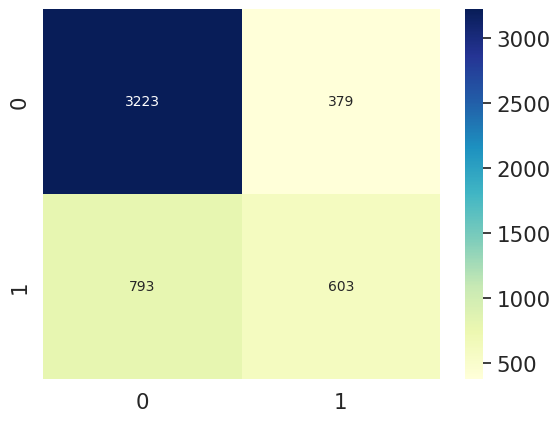

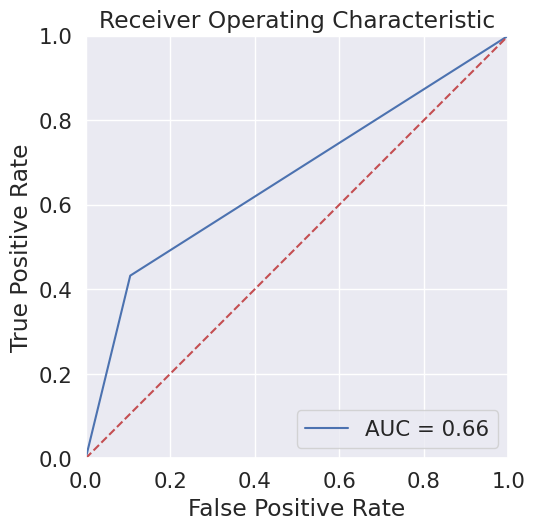

In [48]:
y_pred = model.predict(test)
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(y_test_1, y_pred))
plot_confusion_matrix(y_test_1, y_pred)
plot_roc_curve(y_test_1, y_pred)
# label_map = {'unrelated': 0, 'related': 1}


In [ ]:
# ## Bert
# # create the model, train it on the train dataset and print the scores
# model = MultinomialNB() # as implemented in sklearn
# model.fit(X_numpy, Y_numpy)
# print("Train score:", model.score(train, y_train_1))
# print("Validation score:", model.score(val, y_val_1))

In [61]:
## Bert

X_train_numpy = X_train.numpy()  # convert X tensor to a NumPy array
Y_train_numpy = Y_train.numpy()  # convert Y tensor to a NumPy array
X_val_numpy = X_val.numpy()  # convert X tensor to a NumPy array
Y_val_numpy = Y_val.numpy()  # convert Y tensor to a NumPy array
X_test_numpy = X_test.numpy()  # convert X tensor to a NumPy array
Y_test_numpy = Y_test.numpy()  # convert Y tensor to a NumPy array
# test_bert = np.concatenate((X_test_numpy, Y_test_numpy.reshape(-1, 1)), axis=1)


# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(X_train_numpy, Y_train_numpy)
print("Train score:", model.score(X_train_numpy, Y_train_numpy))
print("Validation score:", model.score(X_train_numpy, Y_train_numpy))

Train score: 0.9375
Validation score: 0.9375


In [70]:
model = MultinomialNB() # as implemented in sklearn
model.fit(X_test_numpy, Y_test_numpy)
print("Train score:", model.score(X_test_numpy, Y_test_numpy))
print("Validation score:", model.score(X_test_numpy, Y_test_numpy))

Train score: 1.0
Validation score: 1.0


In [68]:
# assuming X_train_numpy is the training data and X_test_numpy is the test data
print("Training data shape:", X_train_numpy.shape)
print("Test data shape:", X_test_numpy.shape)

# select the relevant features from the test data
X_test_selected = X_test_numpy[:, :X_train_numpy.shape[1]]

# check that the shapes match
print("Selected test data shape:", X_test_selected.shape)

# make predictions on the modified test data
y_pred = model.predict(X_test_selected)

Training data shape: (32, 538)
Test data shape: (32, 544)
Selected test data shape: (32, 538)


In [65]:
# test
# print("Training data shape:", X_train_numpy.shape)  # replace with the actual variable name for the training features
# print("Test data shape:", test_bert.shape)

Training data shape: (32, 538)
Test data shape: (32, 545)


              precision    recall  f1-score   support

          -1       0.88      0.78      0.82        27
           0       0.25      0.40      0.31         5

    accuracy                           0.72        32
   macro avg       0.56      0.59      0.57        32
weighted avg       0.78      0.72      0.74        32



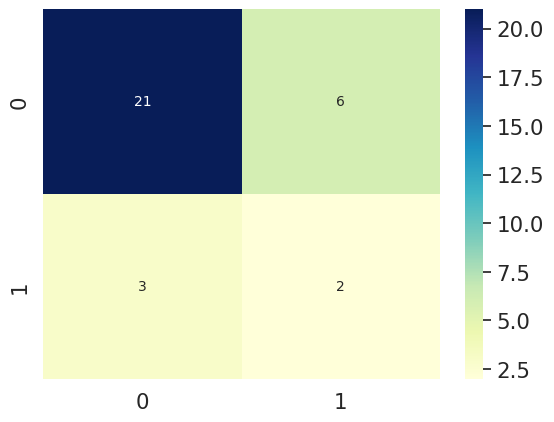

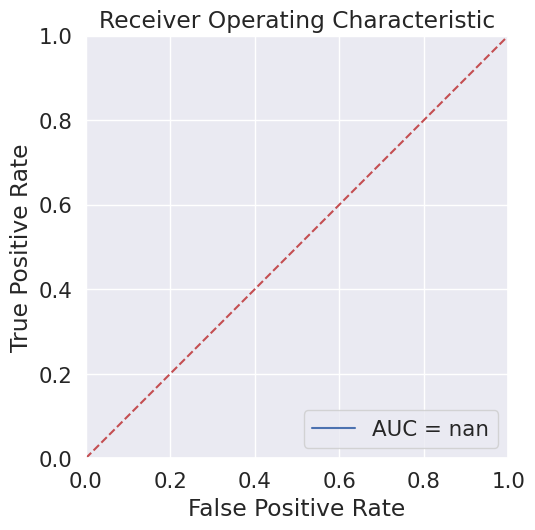

In [69]:
# anticipate the result from X_test
# y_pred = model.predict(X_test_numpy)
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(Y_test_numpy, y_pred))
plot_confusion_matrix(Y_test_numpy, y_pred)
plot_roc_curve(Y_test_numpy, y_pred)
# label_map = {'unrelated': 0, 'related': 1}

Buile the LSTM model for TF-IDF

In [ ]:
from torch import nn
from torch.nn import functional as F

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        text_fea = self.drop(output[:,-1])
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea,1)
        text_out = torch.sigmoid(text_fea)
        return text_out

    
# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))